In [1]:
#importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

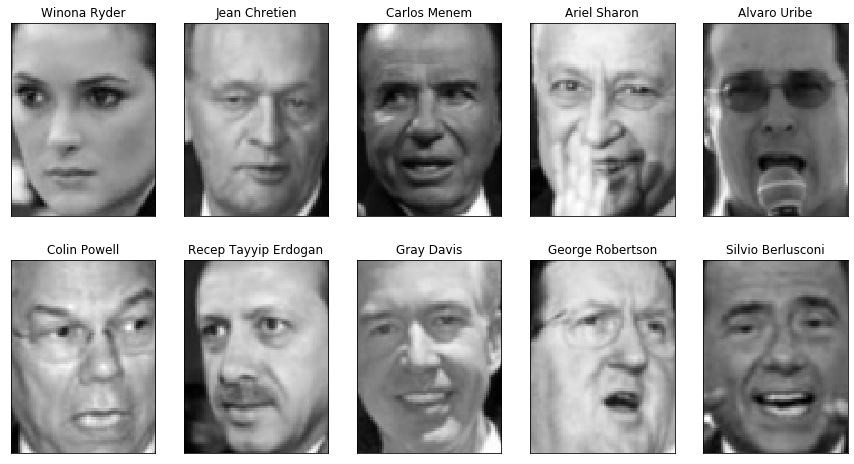

In [2]:
# importing the data set

from sklearn.datasets import fetch_lfw_people
import matplotlib.cm as cm

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])

In [3]:
#finding the properties of dataset

print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [4]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [5]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255

In [6]:
# split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)


In [7]:
#standardizing the feature vector

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis =0, ddof=0)
x_train = (X_train-mean)/std

x_test = (X_test-mean)/std

In [8]:
#finding the covariance and eigen values

cov = np.dot(x_train.transpose(),x_train)/len(x_train)
values, vectors = np.linalg.eig(cov)

In [9]:
#reducing data to 100D data
indices = values.argsort()[-100:][::-1]

w = np.take(vectors,indices,axis =1)

z_train = x_train @ w
z_test = x_test @ w


(5655, 100)


In [10]:
#select 10 random x values as reference vectors

indices =[]


for i in range(0,len(z_train)):
    indices.append(i)

    np.random.seed(0)
np.random.shuffle(indices)

c = z_train[indices[:10]] 

In [11]:
def group(y_pred,k):
    indices = []
    for i in range(0,len(y_pred)):
        if(y_pred[i] == k):
            indices.append(i)
    
    return indices
            

In [12]:
def Ldistance(a,b):
    change  = 0
    for i in range(0,len(a)):
        change = change + abs((a[i] - b[i]))
    return change

In [13]:
y_pred = []
t1 =  np.zeros(100)  

for i in range(0,10000):
        
    for j in range(0,len(z_train)):
        
        prev_distance = 1000
        
        #finding the nearest cluster center for each X_train value 
        for k in range(0,len(c)):
            
            sub = np.subtract(z_train[j], c[k])       
            distance = math.sqrt(np.sum(np.square(sub)))
        
            if (distance < prev_distance):
                index = k  
                prev_distance = distance
                
        y_pred.append(index)         
        
    #updating the cluster values
    for u in range(0,len(c)):
        cluster_index = group(y_pred,u)
        
        cluster_value = np.zeros(100)
        for v in cluster_index:
            
            cluster_value = np.add(cluster_value,z_train[v])
            
        c[u] = cluster_value/len(cluster_index) 
    
    #second stopping condition
    t2 = np.sum(c,axis =0) 
    if  Ldistance(t2,t1) < pow(2,-23):
        break;    
    
    t1 = np.copy(t2)
    y_last = np.copy(y_pred)
    y_pred.clear()  
                

In [14]:
#finding the number of images within each cluster
for i in range(0,10):
    print(i,len(group(y_last,i)))

0 292
1 149
2 203
3 45
4 143
5 95
6 142
7 179
8 133
9 166


In [15]:
#reconstructing the centroid back to original space
centroid = []
for i in range(0,10):
    centroid.append(c[i] @ w.transpose())  

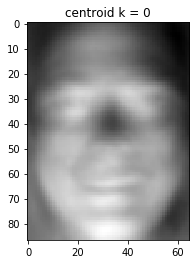

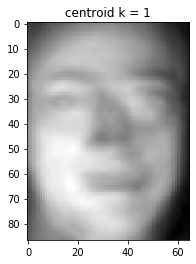

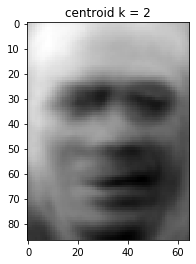

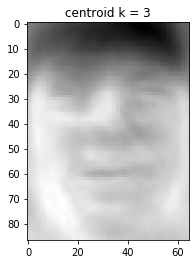

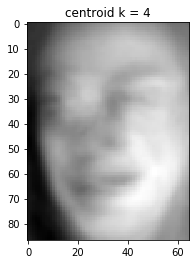

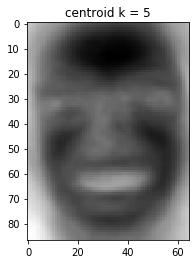

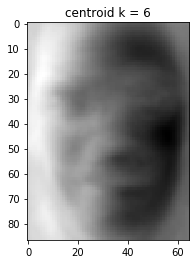

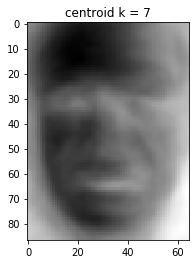

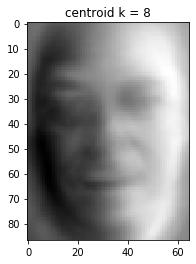

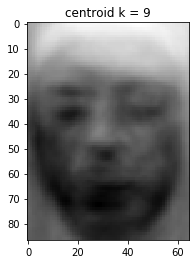

In [16]:
#plotting the centroid values
for i in range(0,10):
    title = "centroid k = "+ str(i)    
    plt.figure()   
    k = np.reshape(centroid[i], (87, 65))
    plt.title(title)
    plt.imshow(k, cmap='gray')
    plt.plot()

In [17]:
#function to find the minimum distance
def minimum(data,cluster):
    
    prev_distance = 1000
    min_index = 0
    for i in range(0,len(data)):    

        sub = np.subtract(data[i], cluster)       
        distance = math.sqrt(np.sum(np.square(sub)))
        if (distance < prev_distance):
            min_index = i  
            prev_distance = distance
    
    return min_index


In [18]:
#function to find the maximum distance
def maximum(data,cluster):
    
    prev_distance = 0
    max_index = 0
    for i in range(0,len(data)):    

        sub = np.subtract(data[i], cluster)       
        distance = math.sqrt(np.sum(np.square(sub)))
        if (distance > prev_distance):
            max_index = i  
            prev_distance = distance
    
    return max_index


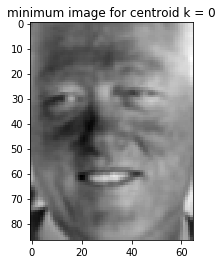

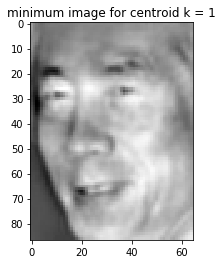

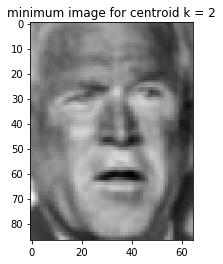

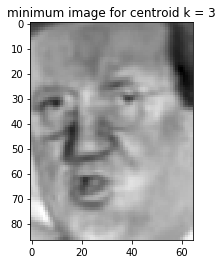

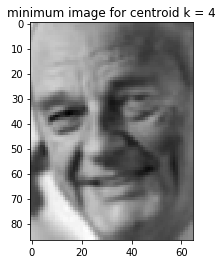

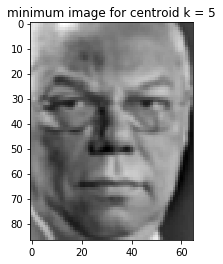

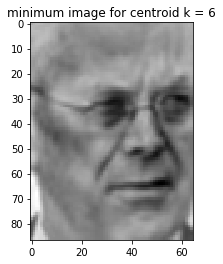

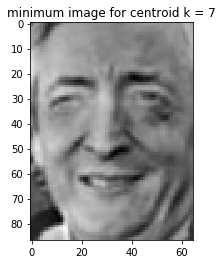

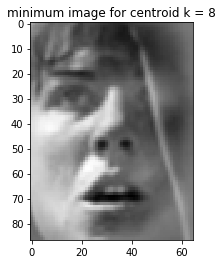

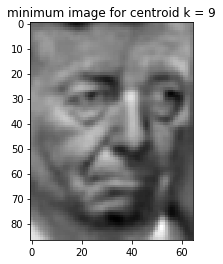

In [19]:
#finding the minimum images for each centroid

for i in range(0,10):
    title = "minimum image for centroid k = "+ str(i) 
    indices = group(y_last,i)
    plt.figure()   
    k = np.reshape(x_train[minimum(z_train[indices],c[i])], (87, 65))
    plt.title(title)    
    plt.imshow(k, cmap='gray')  
    plt.plot()


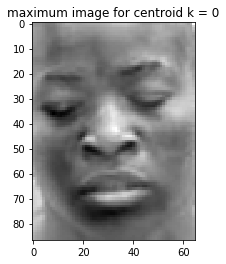

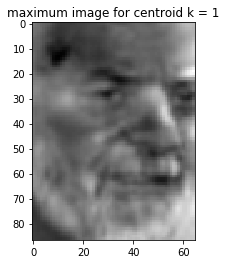

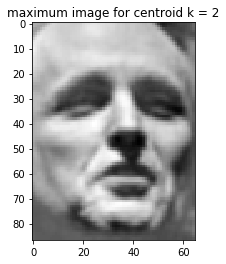

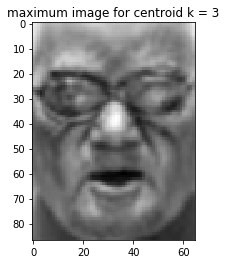

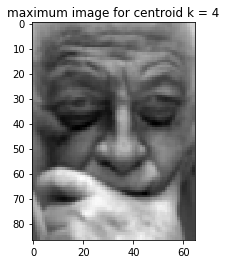

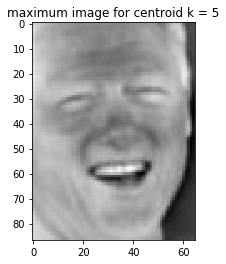

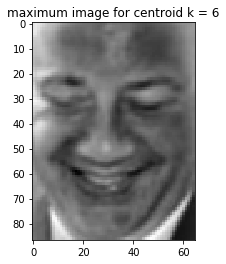

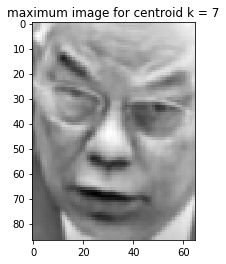

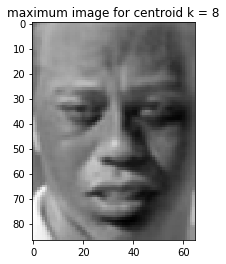

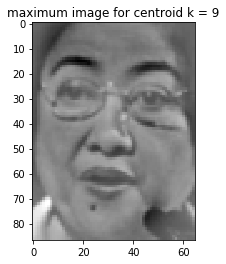

In [20]:
#finding the maximum images for each centroid
for i in range(0,10):
    title = "maximum image for centroid k = "+ str(i)   
    indices = group(y_last,i)
    plt.figure()   
    k = np.reshape(x_train[maximum(z_train[indices],c[i])], (87, 65))
    plt.title(title)
    plt.imshow(k, cmap='gray')  
    plt.plot()